In [185]:
import numpy as np
import os
import pickle
import pandas as pd
import itertools
import matplotlib.pyplot as plt
import pandas.io.data as web
%matplotlib inline

## Here are all of our methods that create the various datapoints on our pandas DataFrame

In [200]:
class Name():
    def __init__(self, means, sd):
        self.mean1 = str(means[0])+"hr"
        self.mean2 = str(means[1])+"hr"
        self.name = self.mean1+"-"+self.mean2
        self.strategy = "Strategy-{}-%.1f".format(self.name) % sd
        self.regime = "Regime-{}-%.1f".format(self.name) % sd
        self.cumsum = "Cumulative-{}-%.1f".format(self.name) % sd
    
    @classmethod
    def from_strategy_name(cls, strat):
        parts = strat.split('-')
        return cls([p.rstrip("hr") for p in parts[1:3]],float(parts[3]))
        

def get_dataframe():
    mydata = None
    try:
        mydata = pickle.load(open('modelling/stats_pickle5', 'rb'))
    except:
        mydata = pickle.load(open('../resources/stats_pickle5', 'rb'))
    df = pd.DataFrame(mydata, columns=["Time", "Value"])
    df = df.set_index('Time')
    return df
    
def create_means(df, means):
    for mean in means:
        df[str(mean)+"hr"] = np.round(pd.rolling_mean(df['Value'], window=mean*60), 2)

def create_diff(dataframe, name):
        dataframe[name.name] = dataframe[name.mean1] - dataframe[name.mean2]

def create_regime(dataframe, name):
    dataframe[name.regime] = np.where(dataframe[name.name] > SD, 1, 0)
    dataframe[name.regime] = np.where(dataframe[name.name] < -SD, -1, dataframe[name.regime])

def set_market(dataframe):
    dataframe['Market'] = np.log(dataframe['Value']/ dataframe['Value'].shift(1))
    dataframe['Market-cumulative'] = dataframe['Market'].cumsum().apply(np.exp)

def create_strategy(dataframe, name):
    dataframe[name.strategy] = dataframe[name.regime].shift(5) * dataframe['Market']

def create_cumsum(dataframe, name):
    dataframe[name.cumsum] = dataframe[name.strategy].cumsum().apply(np.exp)


#The does all of the basic setup and creates a graph that spans the whole of our available data.

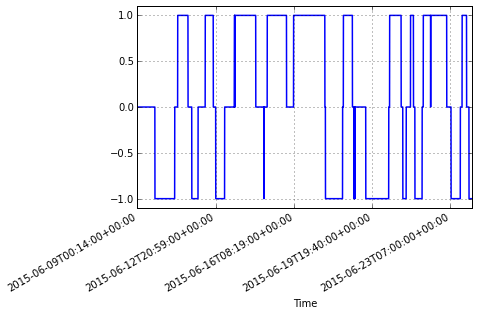

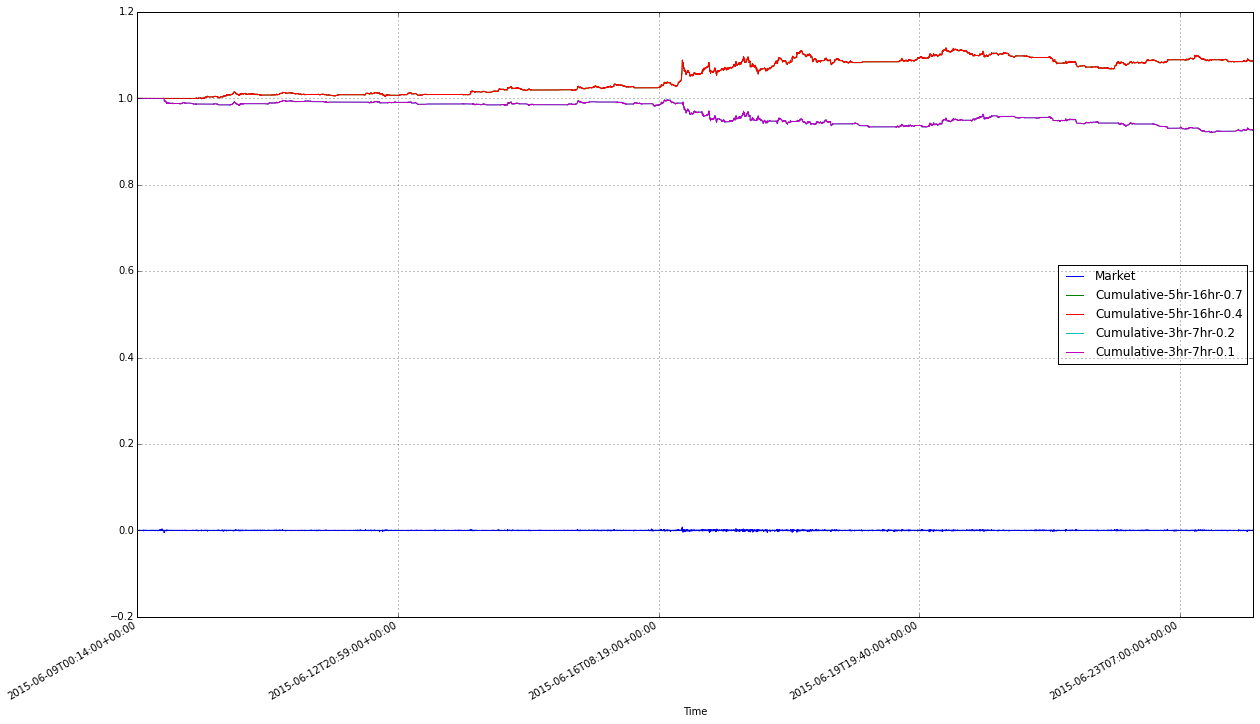

In [202]:
means = range(1,24)
SDs = np.arange(0.1,1,0.1)
df = get_dataframe()
create_means(df,means)
create_diffs(df,means)
set_market(df)

regime_and_strategy_names = [Name(means, sd) for means in list(itertools.combinations(means, 2)) for sd in SDs]
for name in regime_and_strategy_names:
    create_diff(df,name)
    create_regime(df, name)
    create_strategy(df,name)
    create_cumsum(df, name)

df2 = df[[a.cumsum for a in regime_and_strategy_names]][-1:].transpose().sort([df.index.tolist()[-1]],ascending=[0])
column_names = ['Market-']+df2[:2].index.tolist()+df2[-2:].index.tolist()
i = df2[:1].index.tolist()[0]
plota = df[Name.from_strategy_name(i).regime].plot(lw=1.5)
plota.set_ylim([-1.1,1.1])
plota.get_figure().autofmt_xdate()

# df[column_names].tail
plotb = df[column_names].plot(grid=True, figsize=(20,12))
# plotb = df[column_names].plot(grid=True, figsize=(40,25))

plotb.get_figure().autofmt_xdate()

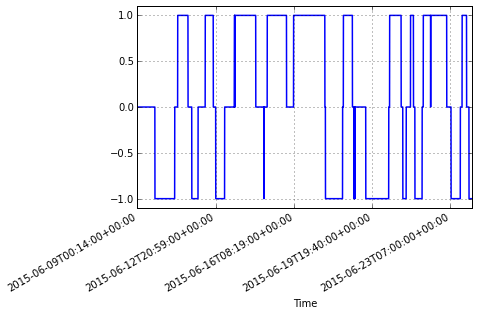

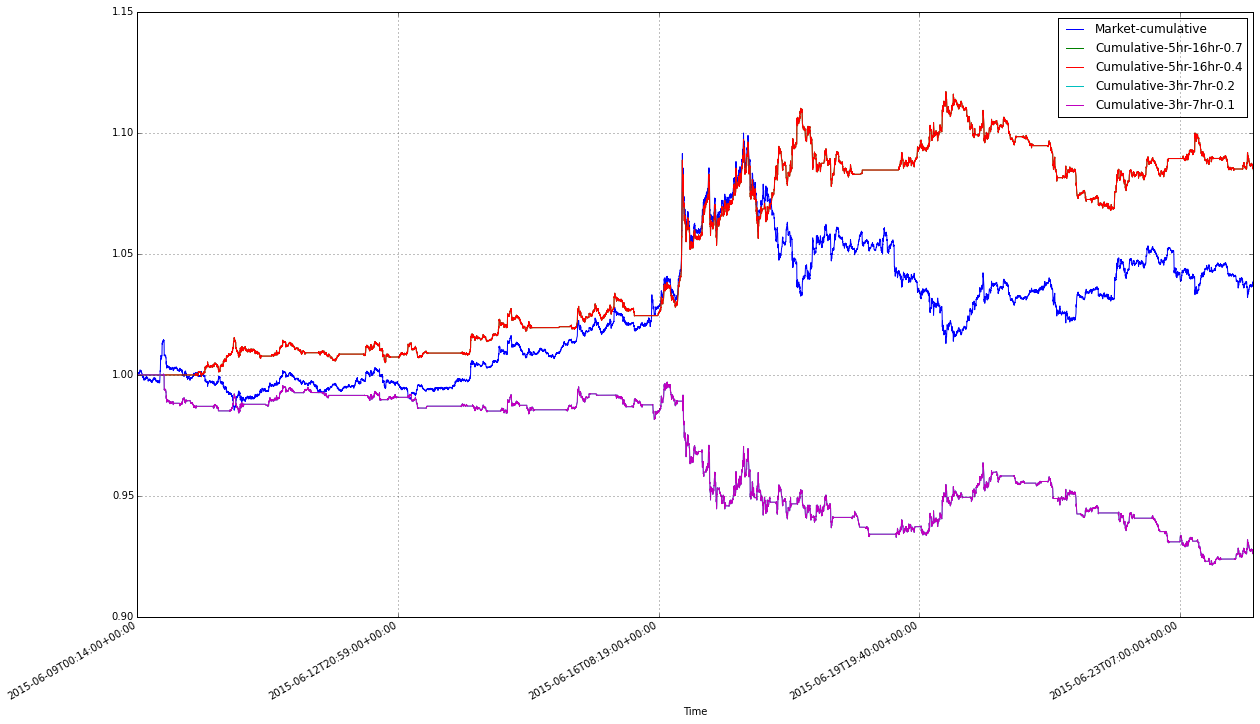

In [203]:
df2 = df[[a.cumsum for a in regime_and_strategy_names]][-1:].transpose().sort([df.index.tolist()[-1]],ascending=[0])
column_names = ['Market-cumulative']+df2[:2].index.tolist()+df2[-2:].index.tolist()
i = df2[:1].index.tolist()[0]
plota = df[Name.from_strategy_name(i).regime].plot(lw=1.5)
plota.set_ylim([-1.1,1.1])
plota.get_figure().autofmt_xdate()

# df[column_names].tail
plotb = df[column_names].plot(grid=True, figsize=(20,12))
# plotb = df[column_names].plot(grid=True, figsize=(40,25))

plotb.get_figure().autofmt_xdate()

#Data for 1 day (best and worst outcomes)

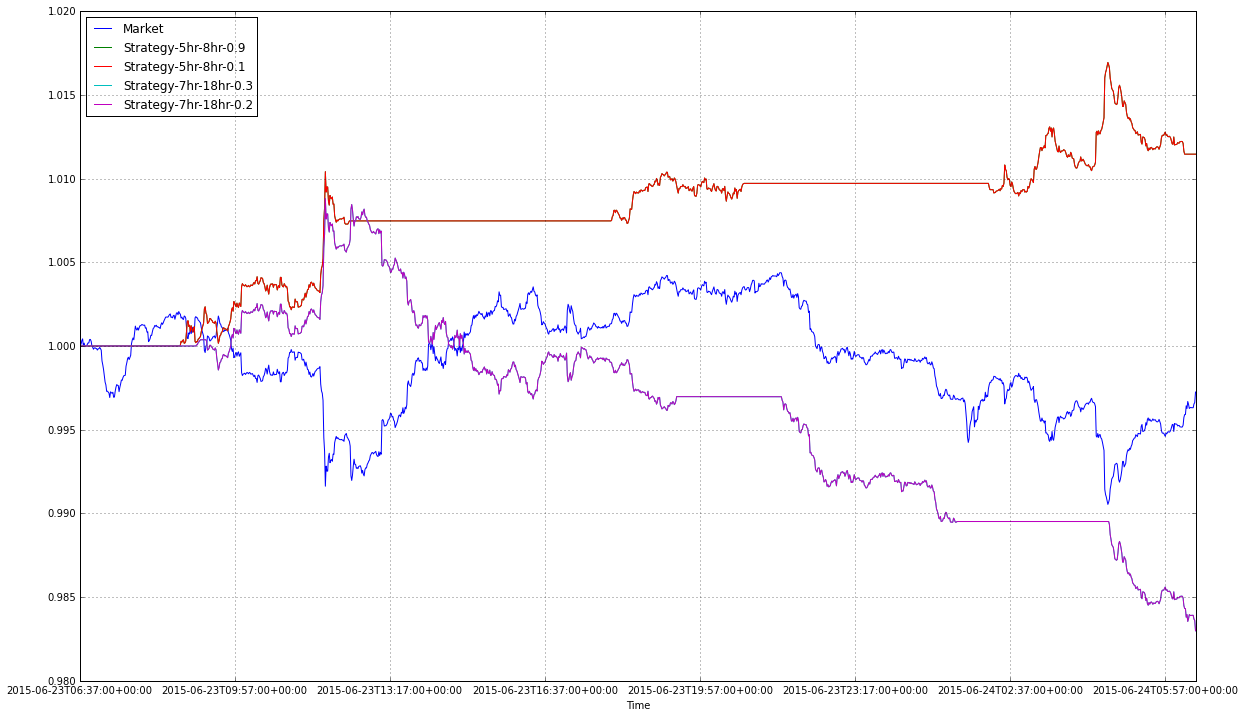

In [205]:
df[-1440:]
last_24 = df[-1440:][[a.strategy for a in regime_and_strategy_names]].cumsum().apply(np.exp)[-1:].transpose().sort([df.index.tolist()[-1]],ascending=[0])
column_names = ['Market']+last_24[:2].index.tolist()+last_24[-2:].index.tolist()
plotb = df[-1440:][column_names].cumsum().apply(np.exp).plot(grid=True, figsize=(20,12))

#Data for 2 days (best and worst)

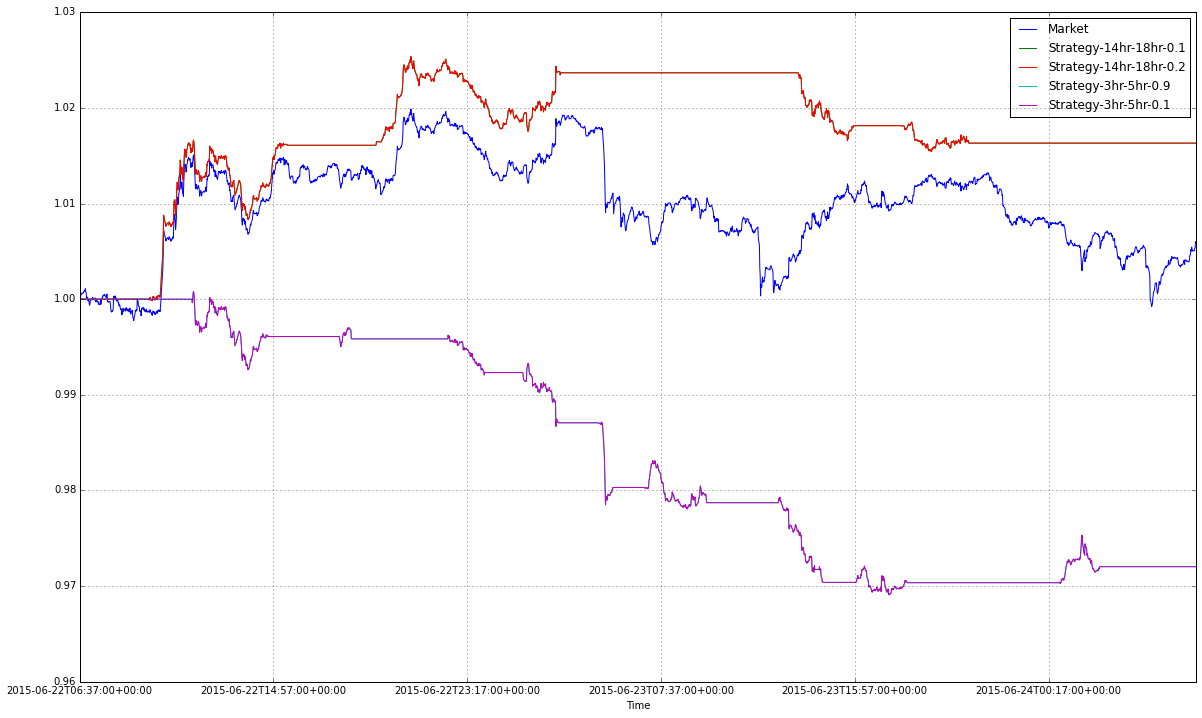

In [189]:
last_24 = df[-2880:][[a.strategy for a in regime_and_strategy_names]].cumsum().apply(np.exp)[-1:].transpose().sort([df.index.tolist()[-1]],ascending=[0])
column_names = ['Market']+last_24[:2].index.tolist()+last_24[-2:].index.tolist()
plotb = df[-2880:][column_names].cumsum().apply(np.exp).plot(grid=True, figsize=(20,12))